# Contenidos

* [1. Modelos lineales generalizados (MLG)](#1.-Modelos-lineales-generalizados-%28MLG%29)
	* [1.1 Tipos de variables: Métricas, ordinales y categóricas.](#1.1-Tipos-de-variables:-Métricas,-ordinales-y-categóricas.)
	* [1.2 La base de los MLG](#1.2-La-base-de-los-MLG)
		* [1.2.1 Modificando los datos antes de muestrear](#1.2.1-Modificando-los-datos-antes-de-muestrear)
		* [1.2.2 Cambiando el método de muestreo](#1.2.2-Cambiando-el-método-de-muestreo)
	* [1.3 Verificación de las predicciones del _a posteriori_](#1.3-Verificación-de-las-predicciones-del-_a-posteriori_)
		* [1.3.1 Interpretando el _a posteriori_](#1.3.1-Interpretando-el-_a-posteriori_)
	* [1.4 Coeficiente de correlación de Pearson](#1.4-Coeficiente-de-correlación-de-Pearson)
		* [1.4.1 Regresión lineal robusta](#1.4.1-Regresión-lineal-robusta)
	* [1.5 Regresión lineal jerárquica](#1.5-Regresión-lineal-jerárquica)
	* [1.6 Polinomios de más alto orden](#1.6-Polinomios-de-más-alto-orden)
	* [1.7 Para seguir leyendo](#1.7-Para-seguir-leyendo)


In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes()
from plot_post import plot_post

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# 1. Modelos lineales generalizados (MLG)

En los cápitulos pasados vimos como crear y analizar modelos Bayesianos, aplicados a distribuciones, binomiales, Poisson, Gaussianas y t de Student. En el presente capítulo veremos un modelo ampliamente usado en estadística el modelo lineal generalizado. Este modelo es la base de métodos como la regresión lineal, regresión multiple, regresión logística y métodos muy conocidos entre los frecuentistas como el _t-test_, ANOVA, etc.

En los modelos lineales generalizados se suele hablar de variables independientes y dependientes, o predictoras y predichas. Por ejemplo si queremos predecir el peso de personas a partir de sus edades, el peso será la variable independiente y la edad la dependiente, pero esos roles se invertirán si en cambio predecimos la edad a partir del peso. La razón del nombre independiente (o predictora) es que el valor de esa variable no es predicho por el modelo si no que es establecido desde afuera del modelo, en otras palabras es una entrada (_input_) del modelo y no un resultado. Hay que tener en claro que cuando hablamos de dependencia es por que **en nuestro modelo** hacemos que una variable dependa de la otra, pero esto no quiere decir, necesariamente, que exista una relación causal entre las variables.

Es decir, usando un MLG lo único que se puede llegar a establecer es la existencia de una relación lineal entre las variables, y por lo tanto la posibilidad de predecir una variable midiendo la otra. Pero hay que dejar en claro que estamos hablando de correlación entre variables no de relación causa-efecto. Es decir dependiendo del diseño experimental un MLG podrá ser usado para establecer una relacion causa-efecto entre variables o solo el grado de correlación entre variables.

Los MLG tienen una forma común, pero su implementación e interpretación dependen de la naturaleza de las variables de interés.

## 1.1 Tipos de variables: Métricas, ordinales y categóricas.

* Métricas o cuantitativas: Son variables con las cuales es posible establecer un orden y computar distancias. Cuando en la escala existe un cero es posible además calcular proporciones, por ejemplo 1 hora es la mitad de 2 horas (por que 0 horas implica la ausencia de tiempo transcurrido). En cambio $40 ^\circ \text{C}$ no es el doble de $20 ^\circ \text{C}$, por que el cero de la escala Celcius es un punto totalmente arbitrario (contrario al cero de la escala Kelvin).
    * Continuas: Se describen usando el conjunto de los reales, algunos ejemplos son la temperatura, altura, peso, etc.
    * Discretas: Se describen usando el conjunto de los enteros, cantidad de hijos, de aviones de una aerolínea, etc.

* Cualitativas: Son el tipo de variables que indican cualidades, o atributos.
    * Categóricas o nominal: Son variables que indican pertenencia a categorías mutuamente excluyentes, como cara o ceca en una moneda. Aún cuando se usen números como 1 y 0 para representar este tipo de variables no se puede decir establecer orden alguno, cara no es más o menos que ceca, ni ceca viene antes que cara. Las variables categóricas no tienen por que ser dos pueden ser millones, como los colores.
    * Ordinales: La variable puede tomar distintos valores ordenados siguiendo una escala establecida, aunque el intervalo no tiene por que ser uniforme, por ej en una carrera de bicicletas, la distancia entre la primer y segunda competidora no tiene por que ser la misma que entre la segunda y la tercera.

## 1.2 La base de los MLG

Lo más probable es que ustedes ya conozcan la base de los MLG, la regresión lineal simple:
    
$$y = \alpha + \beta x $$

En este modelo $x$ se conoce como variable independiente (o variable predictora) e $y$ se conoce como variable dependiente (o variable predicha). $\beta$ es la pendiente e indica el cambio de $y$ por unidad de cambio de $x$, $\alpha$ indica el punto en que la recta corta la ordenada al origen (es decir, el eje de las $y$)

Todos los MLG se pueden considerar variantes de la regresion lineal simple como empezaremos a ver en este capítulo y seguiremos en posteriores. Esta ecuación puede ser resuelta de forma muy eficiente si se la expresa matricialmente y se utiliza lo que se conoce como ecuación normal. Cada vez que ustedes calcularon el ajuste a una recta con algún _software_, lo más probable es que internamente el _software_ haya resuelto la ecuación normal. Este método devuelve los valores para la pendiente y la ordenada al origen que producen el menor error cuadrático medio entre los pares $(x, y)$. Es por ello que el método recibe el nombre de _ajuste por mínimos cuadrados_. Formulado de esa manera estamos frente a un problema de optimización, el objetivo es minimizar una función de de error. 

Este mismo problema se puede pensar de forma probabilística (Bayesiana) lo que nos permite obtener los mejores valores para los parámetros $\alpha$ y $\beta$ junto con una estimación de la incerteza con la que conocemos esos parámetros. Una ventaja adicional es que nos permitirá adaptar facilmente la regresión lineal a modelos que no asumen normalidad o que contienen más parámetros o, en general, que se adaptan mejor a nuestros problemas. Entonces, la regresión lineal simple expresada probabilísticamente queda como:

$$ Y \sim \mathcal{N}(\mu=\alpha + \beta X, \sigma=\epsilon) $$

Es decir los datos $Y$ son generados como una distribución Gaussiana con media $\alpha + \beta X$ y desviación estandard $\epsilon$.

Dado que desconocemos los valores de $\alpha$, $\beta$ y $\epsilon$ debemos fijar _a prioris_, una posibilidad serían los siguientes.

$$\alpha \sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha})$$
$$\beta \sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta}) $$
$$\epsilon \sim U(0, h_{\epsilon}) $$

Si lo que se intenta es usar un _a priori_ ligeramente informativo para $epsilon$ la distribución uniforme con $h_{\epsilon}$, fijado en un valor _grande_ como 100. O más general 10 o 100 veces el valor de la desviación estándar de lo datos. Otra alternativa para _a prioris_ ligeramente informativos es usar una distribución Media-t de student (una distribucion t restringida a valores positivos), con una valor del parámetro _escala_ grande respecto de los datos. Recordemos que la distribución t tiene como casos extremos a la distribución Gaussiana por un lado y a la distribución Cauchy con el otro. Un _a priori _ algo más informativo se puede lograr utilizando por ejemplo una distribución gama.

En todos los siguientes ejemplos usaremos _a prioris_ ligeramente informativos. Recordemos que en problemas reales es posible que contemos con información útil que nos permita usar _a prioris_ algo más informativos.

In [2]:
np.random.seed(1)
N = 100
alfa_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
# y = a + b*x + e
y_real = alfa_real + beta_real * x 
y = y_real + eps_real

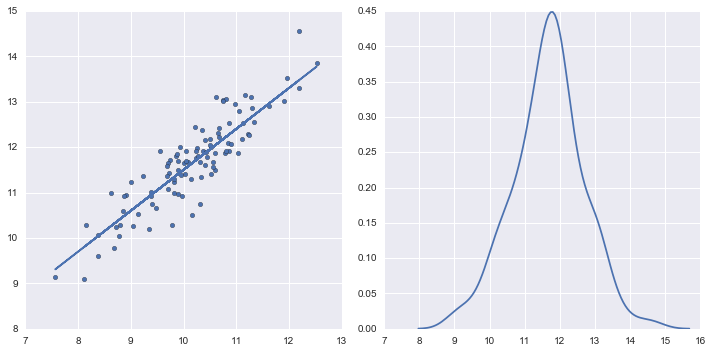

In [3]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(x, y);
plt.plot(x, y_real);
plt.subplot(1,2,2)
sns.kdeplot(y);
plt.tight_layout()

In [4]:
with pm.Model() as modelo:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=100)
    epsilon = pm.Uniform('epsilon', lower=0, upper=100)

    y_pred = pm.Normal('y_pred', mu=alpha + beta * x, sd=epsilon, observed=y)
    
    start = pm.find_MAP() 
    step = pm.Metropolis() 
    trace = pm.sample(10000, step, start, progressbar=True, njobs=4)

Applied interval-transform to epsilon and added transformed epsilon_interval to model.
 [-----------------100%-----------------] 10000 of 10000 complete in 15.7 sec

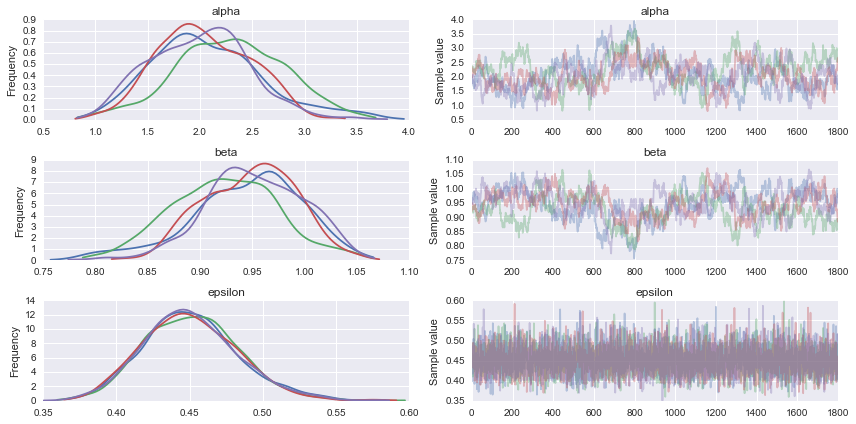

In [5]:
burnin = 1000
thinin = 5
cadena = trace[burnin::thinin]
vars = [alpha, beta, epsilon]
pm.traceplot(cadena, vars=vars);

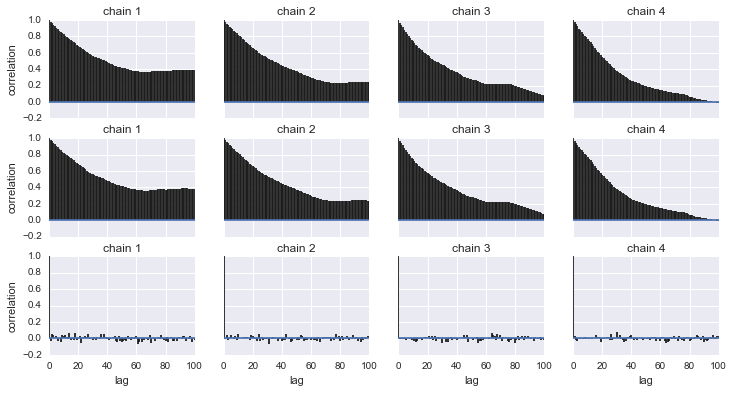

In [6]:
pm.autocorrplot(cadena, varnames=vars);

In [7]:
pm.effective_n(cadena), len(cadena)

({'alpha': 61, 'beta': 61, 'epsilon': 6951, 'epsilon_interval': 5992}, 1800)

In [8]:
#pm.df_summary(cadena_n, vars=vars)

### 1.2.1 Modificando los datos antes de muestrear

En el ejemplo anterior la autocorrelacion para $\alpha$ y $\beta$ es muy alta y por lo tanto el número efectivo de muestras es muy bajo comparado con el número de pasos del MCMC. Claramente el muestreo es malo, pero ¿A qué se debe este mal desempeño?

Todas las posibles rectas que ajusten los datos deben pasar por el punto medio de $x$ y el punto medio de $y$. Alrededor de ese punto al aumentar la pendiente la ordena al origen deberá disminuir y viceversa. Esta correlación puede hacer que el espacio de los valores más plausibles (que es lo que debemos muestrear) sea una "diagonal". Algo como lo siguiente:

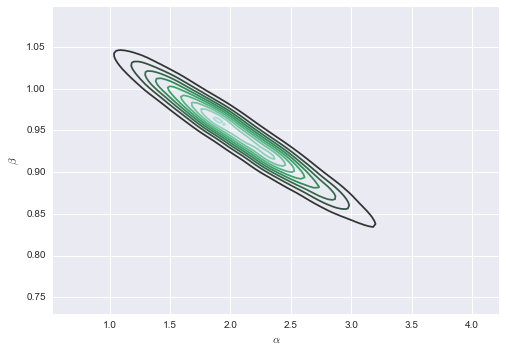

In [9]:
sns.kdeplot(cadena['alpha'], cadena['beta'])
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$');

Para algoritmos como Metropolis-Hastings esto puede ser problemático. Ya que la mayoría de las propuestas serán rechazadas y los valores aceptados estarán fuertemente correlacionados entre si. Imaginen en la figura anterior tener que moverse de una punta al centro de la elipse. Para moverse van alternando entre un paso en $\alpha$ y uno en $\beta$, queda claro que la única forma de moverse por espacios de alta probabilidad es en zig-zag, un pequeño paso en $\alpha$ seguido de un pequeño paso en $\beta$, es decir la convergencia es lenta y cada nuevo paso no puede estar muy lejos del anterior (está correlacionado con el anterior). Este problema aumenta a medida que aumentan las variables/dimensiones del problema. A medida que aumentan las dimensiones disminuye el cociente entre el _volumen_ que corresponde a posiciones de baja probabilidad y el volumen total del espacio muestreable.

Una solución es centrar los datos en $X$, es decir a cada punto $X_i$ restarle la media  para todos los puntos $\bar{X}$. 

$$X^* = X - \bar{X}$$

Como resultado el centro de $X^*$ será 0, es decir el punto alrededor del cual se mueve la recta al cambiar la pendiente será alrededor de la ordenada al origen, por lo que el espacio a muestrear es ahora mas "circular" o menos correlacionado.

El centrar las variables, no solo se hace por razones computacionales. Hay casos en que ayuda a la interpretación de los resultados. Si los datos no están centrados la ordenada al origen es el valor de $Y$ para cuando $X$ vale cero, no en todos los casos esta interpretación  tiene sentido, por ejemplo si las variables fueran peso y altura (no tiene sentido hablar de peso ni altura cero). En cambio al centrar las variables la ordenada al origen pasa a ser el valor de $Y$ para el valor medio de $X$. 

En caso de querer expresar el modelo en términos de la variable $X$ no-centrada, una vez terminado el análisis, habrá que corregir el valor de la ordenada al origen de la siguiente forma:

$$\alpha = \alpha^* - \beta^* \bar{X}$$

Esta corrección es el resultado de:

$$X^* = X - \bar{X}$$
$$Y = \alpha^* + \beta^* X^*$$
$$Y = \alpha^* + \beta^*  (X - \bar{X}) $$
$$Y = \alpha^* - \beta^*  \bar{X}+ \beta^*  X  $$

De donde se puede ver que:

$$\alpha = \alpha^* - \beta^*  \bar{X}$$
$$\beta = \beta^*$$

Queda como ejercicio, hacer la prueba de centrar los datos antes de resolver el modelo y revisar como cambia la autocorrelación de los parámetos durante el muestreo, los resultados obtenidos y la correlación entre $\alpha$ y $\beta$.

En muchos casos no solo resulta conveniente centrar los datos si no que puede ser convenientes estandarizarlos es decir

$$X^* = \frac{X - \bar{X}}{X_{sd}}$$
$$Y^* = \frac{Y - \bar{Y}}{Y_{sd}}$$

Una ventaja de estandarizar los datos, es que siempre es posible aplicar los mismos _a prioris_ ligeramente informativos, sin preocuparse por la escala de los datos.

Estandarizar los datos previo a un análisis es una transformación comunmente aplicada en estadística y _machine learning_. En muchos problemas el rango para distintas variables puede ser muy diferente, incluso ordenes de magnitud diferente esto hace que muchos algoritmos (no solo Metropolis-Hastings) tengan problemas. Por ej cualquier algoritmo que confíe en computar distancias euclídeas se verá afectado, ya que si no se estandariza, el valor de la distancia dependerá fuertemente de la variable con el rango más amplio, minimizando la contribución de las otras variables al computo de la distancia, otro caso corresponde a algoritmos que hacen uso del minimizador _gradiente descendiente_, ya que este algoritmo también deberá zigzagear si las variables no han sido estandarizadas. En definitiva si nuestro método de muestreo tiene problemas es probable que una de las causas sea la falta de estandarización de los datos.

### 1.2.2 Cambiando el método de muestreo

Por supuesto si el problema reside en el método de muestreo una posible solución es usar otros métodos de muestreo. NUTS (y en general el Hamiltonian Monte Carlo, del cual deriva NUTS) fue diseñado precisamente para resolver este tipo de problemas. Para usar NUTS basta con reemplazar _pm.Metropolis()_ por _pm.NUTS()_. NUTS requiere de un parámetro llamado _scaling_, este parámetro le indica algo así como que tan grande pueden ser los pasos en cada dimensión. Si bien NUTS es capaz de estimar este parámetro es recomendable darle un valor inicial razonable, una forma simple de hacer esto es diciéndole que _scaling_ es igual al resultado de _find_MAP()_. Un mal valor de _scalling_ puede hacer que NUTS funcione muy lentamente o que incluso se detenga. Al ser NUTS más eficiente que Metropolis suele ser necesario realizar un muestreo con un menor número de pasos, un periodo _burnin_ más corto y un menor _thining_, todo esto a costa de una mayor costo computacional.

In [10]:
with pm.Model() as modelo_n:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=100)
    epsilon = pm.Uniform('epsilon', lower=0, upper=100)
    
    mu = alpha + beta * x

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    start = pm.find_MAP() 
    step = pm.NUTS(scaling=start) 
    trace_n = pm.sample(10000, step=step, start=start, njobs=4)

Applied interval-transform to epsilon and added transformed epsilon_interval to model.
 [-----------------100%-----------------] 10000 of 10000 complete in 48.0 sec

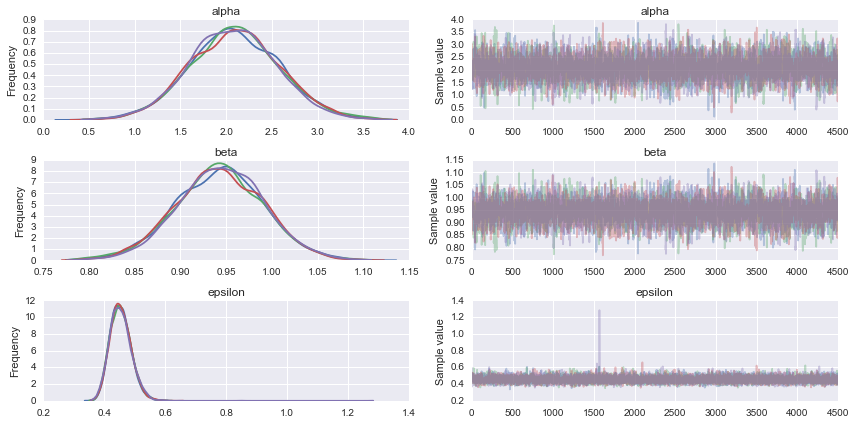

In [11]:
cadena_n = trace_n[1000::2]
pm.traceplot(cadena_n, vars=vars);

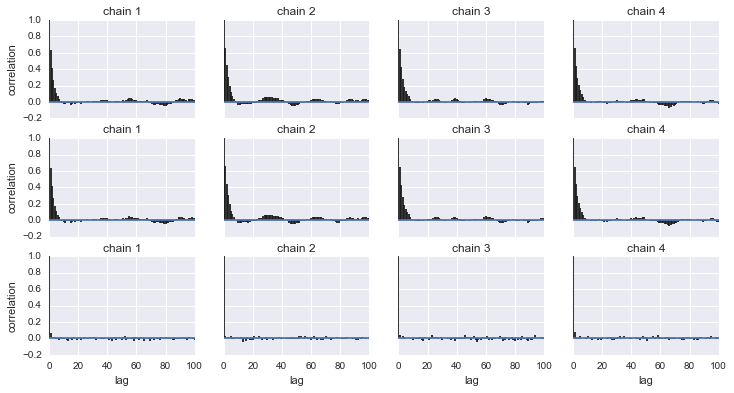

In [12]:
pm.autocorrplot(cadena_n, varnames=vars);

In [13]:
pm.effective_n(cadena_n), len(cadena_n)

({'alpha': 3831, 'beta': 3825, 'epsilon': 15170, 'epsilon_interval': 15451},
 4500)

In [14]:
pm.df_summary(cadena_n, vars=vars)

,mean,sd,mc_error,hpd_5,hpd_95
alpha,2.093325,0.492414,0.008760,1.152080,3.091065
beta,0.943044,0.048274,0.000863,0.845922,1.036593
epsilon,0.454081,0.035250,0.000270,0.388940,0.521022


## 1.3 Verificación de las predicciones del _a posteriori_

In [15]:
ppc = pm.sample_ppc(cadena_n, samples=100, model=modelo_n)

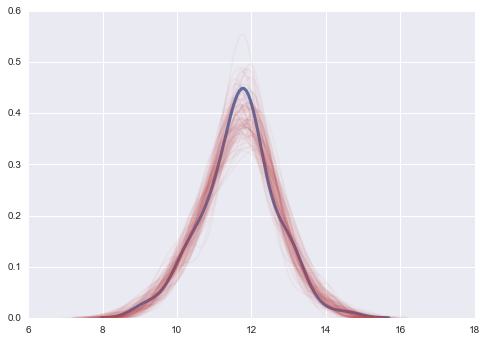

In [16]:
sns.kdeplot(y, linewidth=3)
for i in range(100):
    sns.kdeplot(ppc['y_pred'][i], alpha=0.05, c='r');

### 1.3.1 Interpretando el _a posteriori_

Como ya vimos para otros casos podemos explorar el _a posteriori_ usando las funciones _traceplot_ y _summary_ ofrecidas por PyMC3 o podemos usar nuestras propias funciones. Por ejemplo puede ser útil simplemente hacer una gráfica y reportar los valores medios de $\alpha$ y $\beta$.

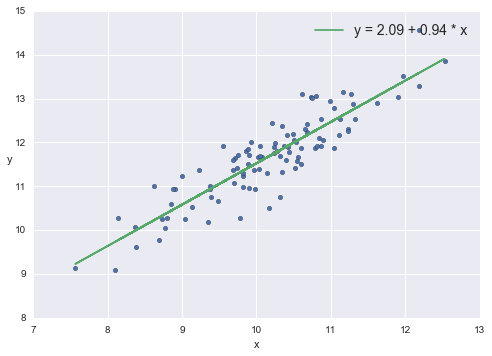

In [17]:
plt.scatter(x, y);
#plt.plot(x, y_real, color='r')
alfa_m = cadena_n['alpha'].mean()
beta_m = cadena_n['beta'].mean()
plt.plot(x, alfa_m + beta_m*x, c='g', label='y = {:.2f} + {:.2f} * x'.format(alfa_m, beta_m))
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=0, fontsize=14);

O hacer una gráfica con rectas semitransparentes tomadas del _a posteriori_, para dar una idea visual de la incertidumbre de nuestra estimación.

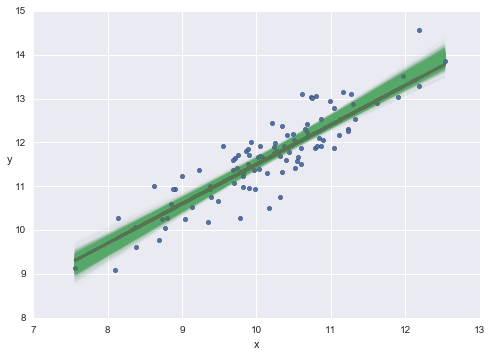

In [18]:
plt.scatter(x, y);
plt.plot(x, y_real, linewidth=3, color='r')
plt.xlabel('x')
plt.ylabel('y', rotation=0)
for i in range(0, len(cadena_n['alpha']), 10):
    plt.plot(x, cadena_n['alpha'][i] + cadena_n['beta'][i]*x, c='g', alpha=0.02);

Cuando realizamos una regresión lineal es posible que solo nos interese saber cual es el cambio de la variable dependiente cuando cambiamos la independiente. En ese caso deberemos mirar el valor de $\beta$, recordemos que el _a posteriori_ contiene toda la información posible sobre $\beta$ dado el modelo y los datos.

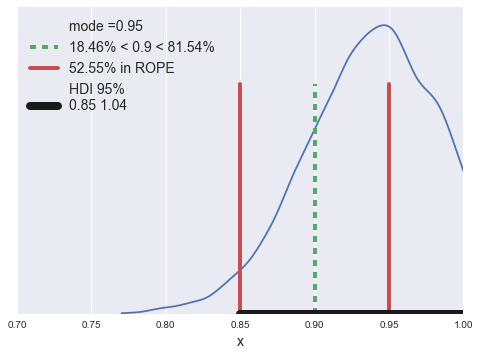

In [19]:
plot_post(cadena_n['beta'], xlab='x', comp_val=.9, ROPE=[0.85,.95])
plt.xlim(0.7, 1);

Podría ser que nos interese determinar si los valores de la pendiente son o no compatibles con algún valor, por ejemplo 0 si lo que intentamos determinar es si existe algun efecto de una variable sobre la otra. O si la pendiente es positiva o negativa, ya que hay estudios previos que indican ambas posibilidades, etc. Como vimos anteriormente esto se puede hacer reportando directamente el _a posteriori_ o reportando el HDI junto con la media o el modo, o haciendo uso de la ROPE.

## 1.4 Coeficiente de correlación de Pearson

Muchas veces al realizar regresiones lineales, además de los parámetros de la recta, nos interesa saber que tan correlacionadas están dos variables. El coeficiente de correlación de Pearson ($r$) es una medida de cuan lineal es la relación entre dos variables, cuando este valor se acerca a ±1 la relación es perfectamente lineal, y cuando $r=0$ no hay linearidad entre las variables. Es muy fácil que se suela confundir a $r$ con la pendiente de la recta $\beta$. La pendiente es una medida del cambio esperado en $y$ por unidad de cambio en $x$. 

En el siguiente gráfico se observan varios conjuntos de puntos y se indica el coeficiente de correlación. En la primer fila se puede ver que $r$ refleja la magnitud de la linearidad entre variables y la dirección (positiva o negativa). En la segunda fila se ve que $r$ no es necesariamente igual a la pendiente, el conjunto de puntos en el centro tiene pendiente 0 pero coeficiente de correlación indefinido (por que la varianza de $y$ es nula). En la última fila se puede observar que $r$ no es capaz de medir relaciones no lineales entre variables.
 
<a href="https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient">
<img border="0" alt="Correlación" src="imagenes/Correlación.png"></a>

Parte de la confusión se origina en que la pendiente y el coeficiente de correlación de Pearson están relacionados como muestra la siguiente expresión:
    
$$\beta = r \frac{sd(Y)}{sd(X)}$$

Entonces podemos decir que la pendiente es el coeficiente de correlación ajustado según la dispersión relativa entre $X$ y $Y$. Estas cantidades son iguales solo si las desviaciones estandard de $X$ y $Y$ son iguales, por ejemplo cuando los datos están estandarizados.

El coeficiente de correlación de pearson $r$ está relacionada con otra cantidad llamada coeficiente de determinación y es simplemente $r^2$. 

A continuación se muestran dos formas de obtener $r^2$, en la linea 9 hemos usado la definición dada mas arriba que relaciona $r$ con la pendiente. En este caso las desviaciones estandard las hemos calculado directamente de los datos, pero si fuese necesario se podrían inferir junto con el resto de los parámetros. En las lineas 11-14 se pueden ver otra forma de calcular $r^2$, es probable que estas lineas le resulten familiares para quienes tengan familiaridad con el método de mínimos-cuadrados. $ss_{reg}$ es una medida de la dispersión entre la linea predicha y la media de los datos, es proporcional a la varianza en el modelo (fijense que la formula es la de una varianza pero sin dividir en la cantidad de observaciones). $ss_{reg}$ es proporcional a la varianza de los datos (solo falta dividir en la cantidad de observaciones). Es por esto que se suele referir al coeficiente de correlación, $r^2$, como la varianza explicada por el modelo.

In [20]:
with pm.Model() as modelo_n:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=100)
    epsilon = pm.Uniform('epsilon', lower=0, upper=100)
    
    mu = alpha + beta * x
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)

    rb = pm.Deterministic('rb', (beta*x.std()/y.std())**2)

    y_mean = y.mean()
    ss_reg = pm.sum((mu-y_mean)**2)
    ss_tot = pm.sum((y-y_mean)**2)
    rss = pm.Deterministic('rss', ss_reg/ss_tot)
       
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start) 
    trace_n = pm.sample(10000, step=step, start=start)

Applied interval-transform to epsilon and added transformed epsilon_interval to model.
 [-----------------100%-----------------] 10000 of 10000 complete in 18.2 sec

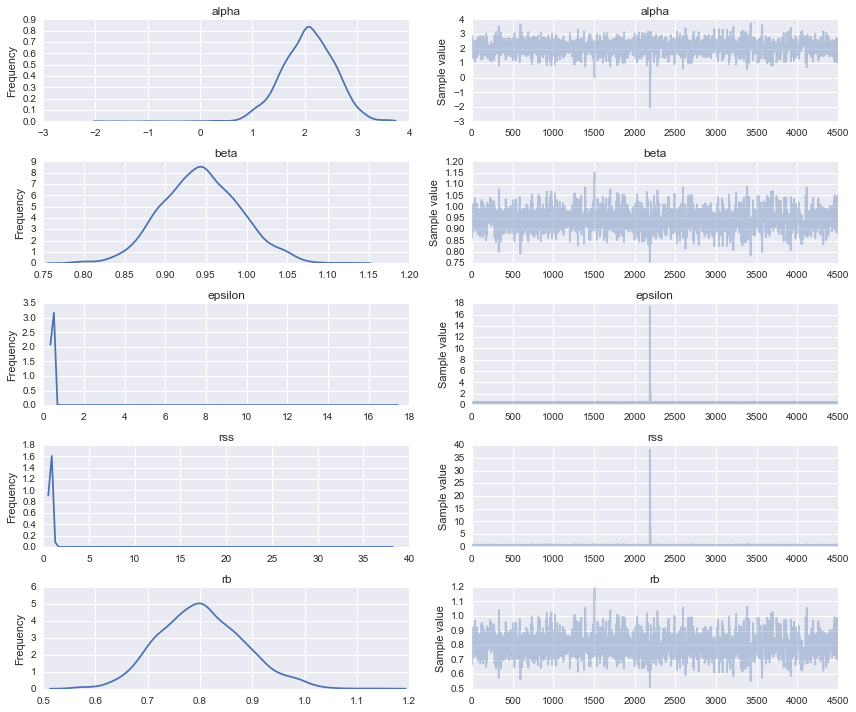

In [21]:
cadena_n = trace_n[1000::2]
vars = [alpha, beta, epsilon, rss, rb]
pm.traceplot(cadena_n, vars=vars);

In [22]:
pm.df_summary(cadena_n, vars=vars)

,mean,sd,mc_error,hpd_5,hpd_95
alpha,2.070042,0.509161,0.018252,1.002868,2.942381
beta,0.944384,0.048330,0.001764,0.857641,1.046442
epsilon,0.465253,0.317049,0.011556,0.384853,0.519552
rss,0.846166,0.985048,0.039677,0.660487,0.984370
rb,0.803431,0.082261,0.003007,0.660887,0.983888


### 1.4.1 Regresión lineal robusta

El supuesto de normalidad de la distribución de los errores es un subproducto de una era en donde las computadoras no existían y por lo tanto los cálculos había que hacerlos a mano, por lo tanto las personas buscaban (razonablemente) formas simples de resolver anaĺíticamente los problemas. Hoy en día no suele ser una restricción el no contar con una solución analítica ya que contamos con numerosos métodos numéricos y sobre todo con computadoras para resolverlos sin demasiado esfuerzo. Esto no quiero decir que resolver problemas analíticamente no sea provechoso, solo que en muchos casos es posible otras aproximaciones. La pregunta ¿Son mis datos normales? suele tener como respuesta invariable, NO!, de todas formas los datos suelen ser lo _suficientemente normales_ como para que los métodos que asumen normalidad funcionen bien. 

Como hicimos en el capítulo anterior usaremos la distribución t de Student en vez de la distribución Gaussiana.

Como ejemplo de la robustez que se puede lograr al cambiar la distribución Normal por una t de Student usaremos el tercer grupo de datos del cuarteto de [Anscombe](https://en.wikipedia.org/wiki/Anscombe's_quartet) (quienes no conozcan este cuarteto no dejen de hacer click en el enlace).

In [23]:
x_3 = np.array([10.0, 8.0, 13.0, 9.0, 11.0, 14.0, 6.0, 4.0, 12.0, 7.0, 5.0])
y_3 = np.array([7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73])

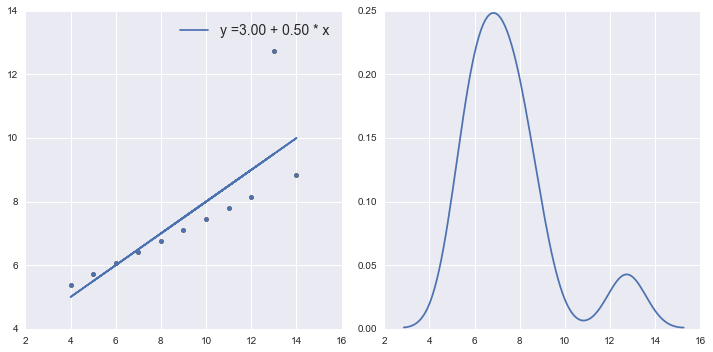

In [24]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
beta_c, alfa_c = stats.linregress(x_3, y_3)[:2]
plt.plot(x_3, (alfa_c + beta_c* x_3), label='y ={:.2f} + {:.2f} * x'.format(alfa_c, beta_c));
plt.scatter(x_3, y_3);
plt.legend(loc=0, fontsize=14)
plt.subplot(1,2,2)
sns.kdeplot(y_3);
plt.tight_layout()

In [25]:
with pm.Model() as modelo_t:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=100)
    epsilon = pm.Uniform('epsilon', lower=0, upper=100)
    nu0 = pm.Exponential('nu0', 1/29)
    nu = pm.Deterministic('nu', nu0 + 1)

    y_pred = pm.StudentT('y_pred', mu=alpha + beta * x_3, sd=epsilon, nu=nu, observed=y_3)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start) 
    trace_t = pm.sample(5000, step=step, start=start)

Applied interval-transform to epsilon and added transformed epsilon_interval to model.
Applied log-transform to nu0 and added transformed nu0_log to model.
 [-----------------100%-----------------] 5000 of 5000 complete in 11.4 sec

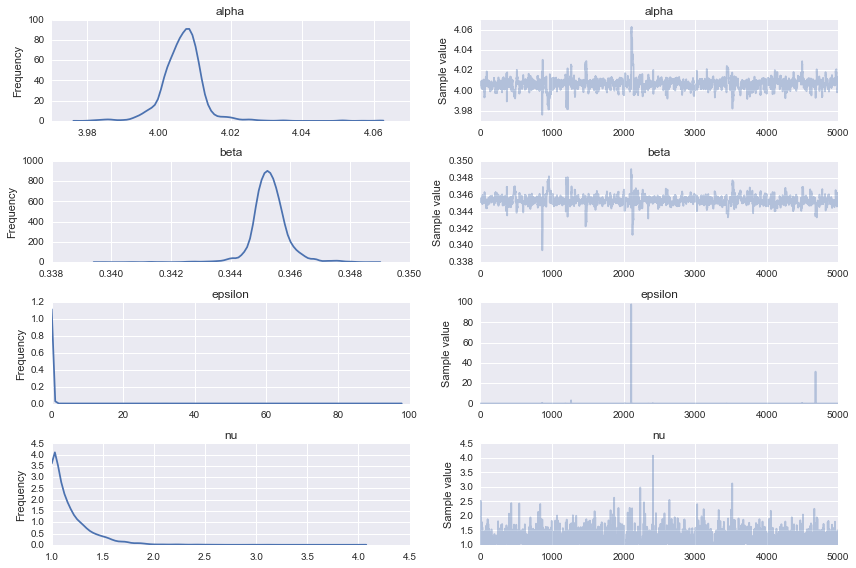

In [26]:
cadena_t = trace_t[::]
pm.traceplot(cadena_t, vars=[alpha, beta, epsilon, nu]);

In [27]:
#pm.autocorrplot(cadena_t);

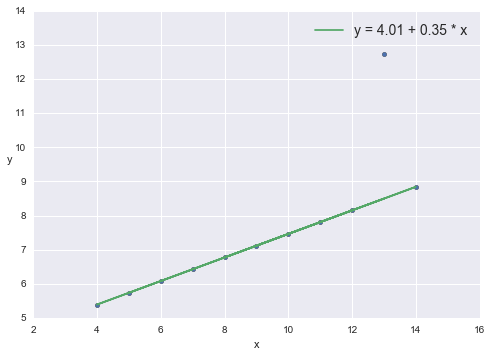

In [28]:
plt.scatter(x_3, y_3);
alfa_m = cadena_t['alpha'].mean()
beta_m = cadena_t['beta'].mean()
plt.plot(x_3, alfa_m + beta_m*x_3, c='g', label='y = {:.2f} + {:.2f} * x'.format(alfa_m, beta_m))
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=0, fontsize=14);

In [29]:
ppc = pm.sample_ppc(cadena_t, samples=1000, model=modelo_t)

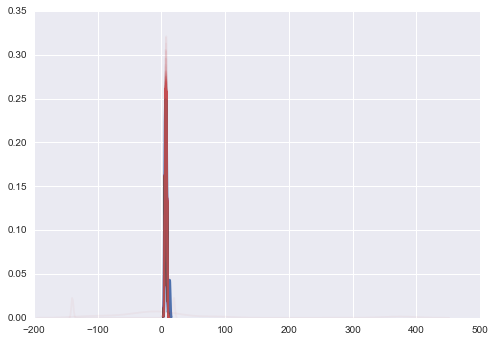

In [30]:
sns.kdeplot(y_3, linewidth=3)
for i in range(1000):
    sns.kdeplot(ppc['y_pred'][i], alpha=0.05, c='r');

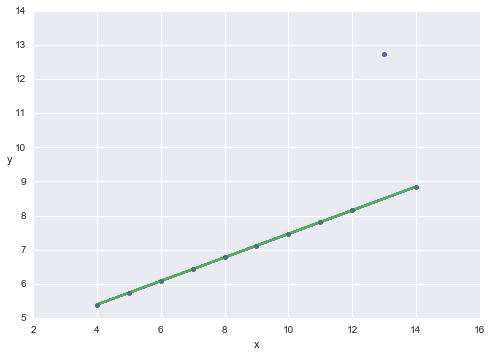

In [31]:
plt.scatter(x_3, y_3);
plt.xlabel('x')
plt.ylabel('y', rotation=0)
for i in range(0, len(cadena_t['alpha']), 10):
    plt.plot(x_3, cadena_t['alpha'][i] + cadena_t['beta'][i]*x_3, c='g', alpha=0.02);

## 1.5 Regresión lineal jerárquica

In [32]:
np.random.seed(1)
N = 20
M = 8
alfa_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(0.9*100, 0.1*100, size=M)
eps_real = np.random.normal(0, 0.5, size=N)

x_m = np.zeros((M, N))
y_m = np.zeros((M, N))
for i in range(M):
    x_m[i] = np.random.normal(10, 1, N)    
    y_m[i] = alfa_real[i] + beta_real[i] * x_m[i]  + eps_real

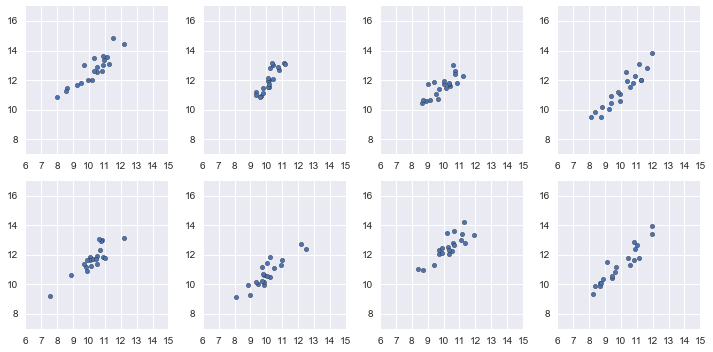

In [33]:
plt.figure(figsize=(10,5))
for i in range(M):
    plt.subplot(2,4,i+1)
    plt.scatter(x_m[i], y_m[i])
    plt.xlim(6, 15)
    plt.ylim(7, 17)
    #print(stats.linregress(x_m[i], y_m[i])[:2])
plt.tight_layout()

In [34]:
idx = np.repeat(range(M), N)
x_f = x_m.flatten() - x_m.mean() # vamos a centrar los datos para facilitar el muestreo
y_f = y_m.flatten()

In [35]:
with pm.Model() as modelo_desagrupado:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=100, shape=M)
    beta = pm.Normal('beta', mu=0, sd=100, shape=M)
    epsilon = pm.Uniform('epsilon', lower=0, upper=100)
    nu0 = pm.Exponential('nu0', 1/29)
    nu = pm.Deterministic('nu', nu0 + 1)

    y_pred = pm.T('y_pred', mu=alpha_tmp[idx] + beta[idx] * x_f, sd=epsilon, nu=nu, observed=y_f)

    # correjimos alfa para que esté en la escala original de los datos
    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean()) 
    
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start) 
    trace_d = pm.sample(2000, step=step, start=start)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '4278' (I am process '4717')


Applied interval-transform to epsilon and added transformed epsilon_interval to model.
Applied log-transform to nu0 and added transformed nu0_log to model.


AttributeError: module 'pymc3' has no attribute 'T'

In [ ]:
cadena_d = trace_d[::]
vars=[alpha, beta, epsilon, nu]
pm.traceplot(cadena_d, vars=vars);

In [ ]:
#pm.autocorrplot(cadena_d, vars=[epsilon, nu]);

In [ ]:
pm.summary(cadena_d, vars=vars)

In [ ]:
alfa_real

In [ ]:
beta_real

Tenemos dos opciones aumentar la cantidad de datos, que para los datos sintéticos es tan simple como aumentar N (de hecho eso es un buen ejercicio), pero que en la realidad puede ser dificil, engorroso o incluso imposible o podemos hacer un modelo jerárquico.

In [ ]:
with pm.Model() as modelo_agrupado:
    # hyper-priors
    alpha_tmp_mu = pm.Normal('alpha_tmp_mu', mu=0, sd=100)
    alpha_tmp_sd = pm.Uniform('alpha_tmp_sd', lower=0.1, upper=100)
    beta_mu = pm.Normal('beta_mu', mu=0, sd=100)
    beta_sd = pm.Uniform('beta_sd', lower=0.1, upper=100)
    
    # a prioris
    alpha_tmp = pm.Normal('alpha_tmp', mu=alpha_tmp_mu, sd=alpha_tmp_sd, shape=M)
    beta = pm.Normal('beta', mu=beta_mu, sd=beta_sd, shape=M)
    epsilon = pm.Uniform('epsilon', lower=0, upper=100)
    nu0 = pm.Exponential('nu0', 1/29)
    nu = pm.Deterministic('nu', nu0 + 1)

    y_pred = pm.T('y_pred', mu=alpha_tmp[idx] + beta[idx] * x_f, sd=epsilon, nu=nu, observed=y_f)

    # correjimos alfa para que esté en la escala original de los datos
    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean()) 
    
    start = pm.find_MAP()
    #step = pm.NUTS(scaling=start) 
    step = pm.Metropolis()
    trace_a = pm.sample(20000, step=step, start=start)

In [ ]:
cadena_a = trace_a[::]
vars=[alpha, beta, epsilon, nu]
pm.traceplot(cadena_a, vars=vars);

In [ ]:
alfa_real

In [ ]:
pm.summary(cadena_a, vars=vars)

## 1.6 Polinomios de más alto orden

$y = \beta_0 x^0 + \beta_1 x^1 + \beta_2 x^2 + \beta_3 x^3 ... + \beta_n x^n$

La anterior ecuación muestra un polinomio de grado n. Si hacemos que todo los coeficientes $\beta_n$ para $n > 1$ igual a cero, recuperamos la ecuación de la recta que hemos venido usando:

$y = \alpha + \beta * x$

Por lo tanto todos los modelos lineales que hemos visto hasta ahora pueden ser _expandidos_ para representar relaciones no lineales!

In [ ]:
x_2 = np.array([ 10.,   8.,  13.,   9.,  11.,  14.,   6.,   4.,  12.,   7.,   5.])
y_2 = np.array([ 9.14,  8.14,  8.74,  8.77,  9.26,  8.1 ,  6.13,  3.1 ,  9.13,
        7.26,  4.74])

In [ ]:
plt.scatter(x_2, y_2);

In [ ]:
with pm.Model() as modelo_c:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta1 = pm.Normal('beta1', mu=0, sd=100)
    beta2 = pm.Normal('beta2', mu=0, sd=100)
    epsilon = pm.Uniform('epsilon', lower=0, upper=100)
    nu0 = pm.Exponential('nu0', 1/29)
    nu = pm.Deterministic('nu', nu0 + 1)

    mu = alpha + beta1 * x_3 + beta2 * x_3**2
    
    y_pred = pm.T('y_pred', mu=mu, sd=epsilon, nu=nu, observed=y_3)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start) 
    trace_c = pm.sample(5000, step=step, start=start)

In [ ]:
cadena_c = trace_c[::]
pm.traceplot(cadena_c, vars=[alpha, beta1, beta2, epsilon, nu]);

In [ ]:
x_p = np.linspace(4, 14, 50)
y_p = cadena_c['alpha'].mean() + cadena_c['beta1'].mean() * x_p + cadena_c['beta2'].mean() * x_p**2
plt.scatter(x_3, y_3)
plt.plot(x_p, y_p, c='r');

Si el modelo lineal es un súbmodelo de un polinomio de grado 2 (o en general de grado $n \ge 2$). Entonces esto quiere decir que un polinomio de grado 2 no solo ajusta curvas más o menos parabólicas, si no que además ajusta puntos que siguen una relación más o menos lineal, en ese caso $\beta_2$ simplemente valdrá cero. Este es un buen momento para dejar de leer y usar el modelo anterior para ajustar x_3 e y_3 (el tercer conjunto de datos del cuarteto de Anscombe).

Si realmente dejaron de leer e hicieron el ejercicio propuesto habrán comprobado por ustedes mismos que se puede usar un modelo cuadrático para ajustar una recta. Una posible conclusión de este ejercicio es que no habría razón para detenerse en un polinomio de grado 2, si no que deberíamos usar polinomios de grado infinito! Hay al menos dos formas de poner esta idea en práctica:

* La versión ingenua: Como veremos en detalle en el capítulo XX el problema de esta aproximación es que conduce a _sobreajustar_ los datos (_overfitting_). Esto sucede cuando el modelo no solo ajusta (o _aprende_ en términos de _machine learning_) los datos si no que empieza a ajustar también el ruido. Es decir en vez de obtener un modelo que es una buena generalizacion de los datos obtenemos un modelo que es una buena _particularización_ de los datos, explica tan bien los _detalles_ que no sirve explicar otros conjuntos de datos similares.

* Los modelos no-paramétricos: Todos los modelos Bayesianos que hemos visto hasta ahora son paramétricos. Es decir, nuestro objetivo ha sido dado un modelo y un conjunto de datos determinar los parámetros de ese modelo. El único caso de aproximación no-paramétrica que hemos visto ha sido el KDE (pero que no es Bayesiana), en el KDE por cada nuevo punto que tengamos en los datos se suma una nueva Gaussiana. De forma similar, los modelos Bayesianos no paramétricos no es que no tenga parámetros si no que el número de parámetros aumenta a medida que aumentan los datos. En este curso NO veremos modelos Bayesianos no-paramétricos. Quien tenga interes en seguir leyendo sobre este tema puede buscar información usando los términos Procesos Gaussianos (Gaussian processes) y Procesos de Dirichlet (Dirichlet processes).

## 1.7 Para seguir leyendo

* Más sobre modelos generalizados lineales en:
    * Capítulos 15, 17 de Doing Bayesian Data Analysis de Kruschke (2 [edición](www.amazon.com/gp/product/0124058884))
    * Capítulos 14 a 17 de [Bayesian Data Analysis](www.amazon.com/Bayesian-Analysis-Chapman-Statistical-Science/dp/1439840954) de Andrew Gelman


* Material online con tópicos Bayesianos:
    * [Publishable Stuff](http://sumsar.net/)
    * [Probably Overthinking It](http://allendowney.blogspot.com.ar/)
    * [Pythonic Perambulations](http://jakevdp.github.io./)
    * [While My MCMC Gently Samples](http://twiecki.github.io/)
    * [Count Bayesie](https://www.countbayesie.com/)
    * [Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/#contents)   


* Las plantillas utilizadas para generar los diagramas de Kruschke, fueron creadas por [Rasmus Bååth's](http://sumsar.net/blog/2013/10/diy-kruschke-style-diagrams/)

In [ ]:
import sys, IPython, scipy, matplotlib, platform
print("Esta notebook fue creada en una computadora %s corriendo %s y usando:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))